# Bank Customer Segmentation and Value Prediction
## Exploratory Data Analysis
### MidTerm Project
### October 2023
#### *Author*: Javier Blanco

## 1. Import dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns
plt.style.use("fivethirtyeight")
%matplotlib inline

## 2. Dataset
We are going to analyze full dataset, although it was already splitted as Train, Validation and Test files using PowerQuery Editor in PowerBI.

In [2]:
data_raw = pd.read_csv('../dataset/bank_transactions.csv', sep=',')
data_raw.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


### 2.1. Data Information

In [3]:
columns_info = dict(zip(data_raw.columns, data_raw.dtypes.apply(lambda x: x.name).to_list()))
columns_info

{'TransactionID': 'object',
 'CustomerID': 'object',
 'CustomerDOB': 'object',
 'CustGender': 'object',
 'CustLocation': 'object',
 'CustAccountBalance': 'float64',
 'TransactionDate': 'object',
 'TransactionTime': 'int64',
 'TransactionAmount (INR)': 'float64'}

### 2.2. Transfomation

In [4]:
# Missing Values identification
data_raw.isna().sum()

TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64

In [5]:
max_nan_len = data_raw.isna().sum().max()
total_data_len = data_raw.shape[0]
prop = round((max_nan_len/total_data_len)*100,2)
print(f'Ratio NANs over total is: {prop}%')

Ratio NANs over total is: 0.32%


In [6]:
df = data_raw.dropna()
df.isna().sum()

TransactionID              0
CustomerID                 0
CustomerDOB                0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
dtype: int64

In [7]:
df = df[df['CustomerDOB'] != '1/1/1800']
df = df.rename(columns={'TransactionAmount (INR)':'transaction_amount',
                        'CustomerDOB': 'date_of_birth',
                        'CustGender':'gender',
                        'TransactionDate': 'transaction_date',
                        'CustLocation': 'location',
                        'CustomerID' : 'customer_id',
                        'TransactionID': 'transaction_id',
                        'CustAccountBalance': 'account_balance',
                        'TransactionTime':'transaction_time'})
df.head()

,transaction_id,customer_id,date_of_birth,gender,location,account_balance,transaction_date,transaction_time,transaction_amount
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


Now, we need to perform some important operations in order to prepare dates of dataset. First, we are going to calculate the current year and date using the datetime.now() function. Then, `transaction_date` column will be converted from a string format to datetime format with the format `%d/%m/%y`, handling any errors by replacing problematic entries with NaT.

The `transaction_time` column, initially in a numeric format, is converted to a time format (`%H:%M:%S`).

Also, we create a new column `gender_int` where 'F' values are mapped to 1 and 'M' values to 0 based on the `gender` column.

In addition, `date_of_birth` column will be converted to datetime format and any dates greater than the current year are adjusted by subtracting 100 years.

Finally, we calculate the `age` column by subtracting `date_of_birth` from the current date, representing the age in years using the `<m8[Y]` timedelta unit.

In [8]:
current_year = datetime.now().year
current_date = pd.to_datetime('now')
df['transaction_date'] = pd.to_datetime(df['transaction_date'], format='%d/%m/%y', errors='coerce')
df['transaction_time'] = df['transaction_time'].apply(lambda x: datetime.strptime(str(x).zfill(6), '%H%M%S').time())
df['gender_int'] = df['gender'].apply(lambda x: 1 if x == 'F' else 0)
df['date_of_birth'] = pd.to_datetime(df['date_of_birth'], format='%d/%m/%y')
df['date_of_birth'] = df['date_of_birth'].apply(lambda x: x.replace(year=x.year - 100) if x.year > current_year else x)


In [9]:
df['age'] = current_date - df['date_of_birth']
df['age'] = df['age'] // np.timedelta64(1, 'Y')

Transaction amount and account balance must be shown as logarithm in order to normalize data

In [10]:
columns_info = dict(zip(df.columns, df.dtypes.apply(lambda x: x.name).to_list()))
columns_info

{'transaction_id': 'object',
 'customer_id': 'object',
 'date_of_birth': 'datetime64[ns]',
 'gender': 'object',
 'location': 'object',
 'account_balance': 'float64',
 'transaction_date': 'datetime64[ns]',
 'transaction_time': 'object',
 'transaction_amount': 'float64',
 'gender_int': 'int64',
 'age': 'int64'}

## 3. Summary Statistics
Basic statistics: mean, median, minimum, maximum, standard deviation, and quartiles for numerical columns

In [11]:
stats = df[['account_balance','transaction_amount', 'age']]
np.round(stats.describe(),2)

,account_balance,transaction_amount,age
count,9.853220e+05,985322.00,985322.00
mean,1.060612e+05,1452.43,37.88
std,8.179053e+05,6139.77,8.76
min,0.000000e+00,0.00,0.00
25%,4.582130e+03,151.00,32.00
50%,1.600630e+04,431.00,36.00
75%,5.375908e+04,1125.00,41.00
max,1.150355e+08,1560034.99,99.00


There is Outliers. We should handle them

## 4. Data Distribution

We want to explore the distribution of numerical variables using histograms or box plots to understand the range and spread of the data.
For categorical variables like `gender`, `location`, and `transaction_date`, we may create bar plots to visualize the distribution of categories.

* Numerical Variables
Logarithm of `account_balance` and `transaction_amout` have been calculated in order to normalize data and perform plots

In [12]:
df['log_account_balance'] = round(np.log10(df['account_balance']),2)
df['log_transaction_amount'] = round(np.log10(df['transaction_amount']),2)

c:\Users\javie\miniconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\javie\miniconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Account Balance, Transaction Amount and Customer Age distributions have been drawn:

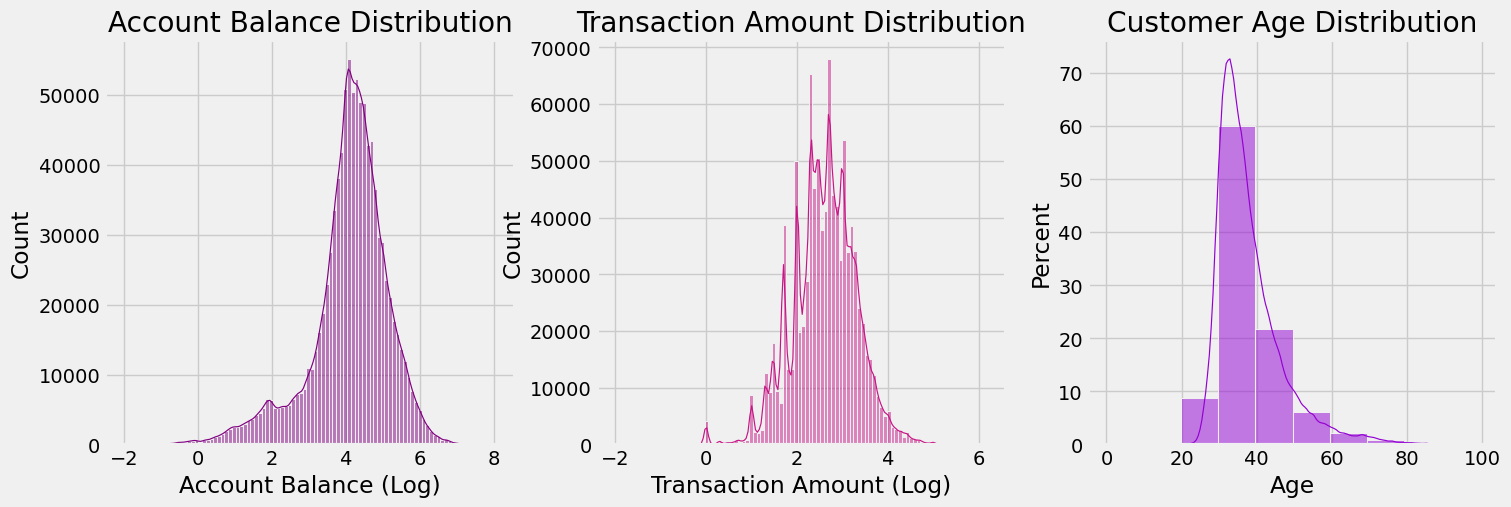

In [13]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
sns.histplot(df['log_account_balance'],
             bins=100,
             kde=True,
             color='purple',
             linewidth = .75,
             line_kws=dict(linewidth=0.85))
plt.title('Account Balance Distribution')
plt.xlabel('Account Balance (Log)')
plt.subplot(1, 3, 2)
sns.histplot(df['log_transaction_amount'],
             bins=100,
             kde=True,
             color='mediumvioletred',
             linewidth = .75,
             line_kws=dict(linewidth=0.85))
plt.title('Transaction Amount Distribution')
plt.xlabel('Transaction Amount (Log)')
plt.subplot(1, 3, 3)
sns.histplot(df['age'],
             bins=10,
             kde=True,
             stat= 'percent',
             color='darkviolet',
             linewidth = .75,
             line_kws=dict(linewidth=0.85))
plt.title('Customer Age Distribution')
plt.xlabel('Age')
plt.show()

In [14]:
q3_account_balance = round(np.exp(df['log_account_balance'].describe()[6]),2)
q3_account_balance

113.3

In [15]:
q3_frequent_transaction_amount = round(np.exp(df['log_transaction_amount'].describe()[6]),2)
q3_frequent_transaction_amount

21.12

In [16]:
data_times = pd.to_datetime(df['transaction_time'], format='%H:%M:%S')
data_times = data_times.dt.hour

* Categorical Variables (gender)

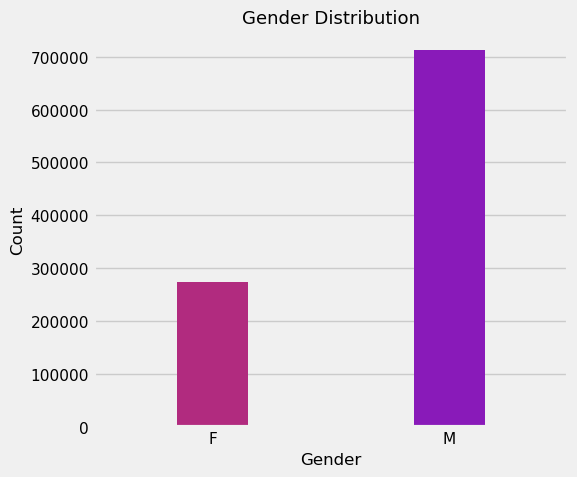

In [17]:
plt.figure(figsize=(6, 5))
custom_palette = sns.color_palette(['mediumvioletred','darkviolet'])
sns.countplot(df, x='gender',width=0.3, palette=custom_palette)
plt.title('Gender Distribution', fontsize=13)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()

## 5. Correlation Analysis:

We want to check for correlations between numerical variables using correlation matrices. This can help identify relationships between different numerical features.

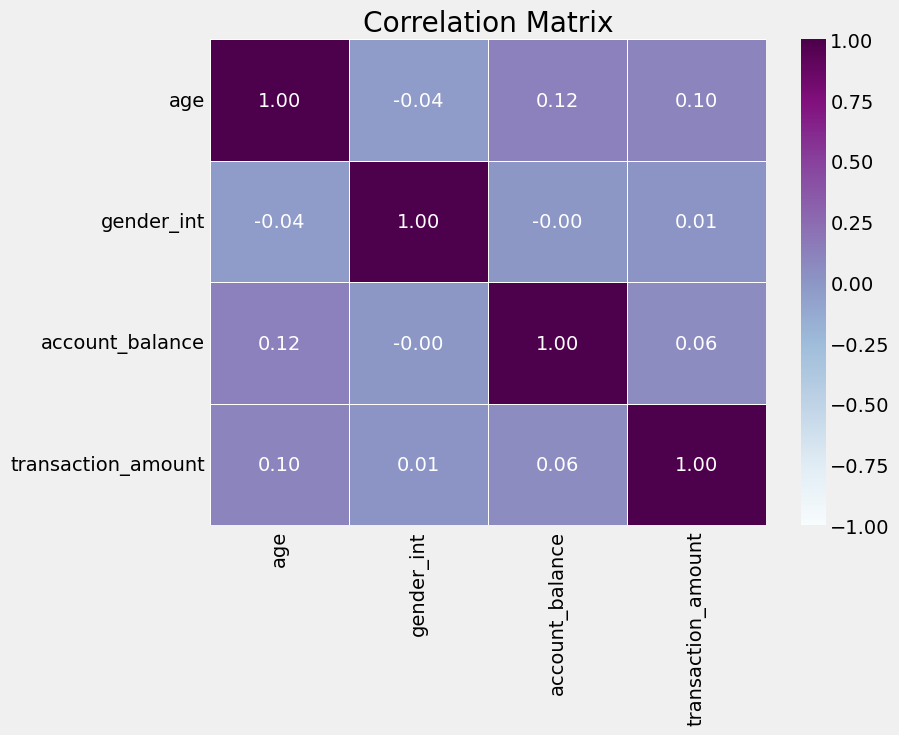

In [27]:
# corr_df = df.drop(columns=['log_transaction_amount',
#                            'log_account_balance',
#                            'transaction_id',
#                            'customer_id',
#                            'gender',
#                            'location',
#                            'transaction_date',
#                            'transaction_time'])

corr_df = df[['age', 'gender_int', 'account_balance', 'transaction_amount']]
correlation_matrix = corr_df.corr()
matrix = np.triu(correlation_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='BuPu',
            fmt='.2f',
            linewidths=0.5,
            vmin=-1, vmax=1,
            center= 0)
plt.title('Correlation Matrix')
plt.show()

## 6. Customer Analysis:

Analyze the distribution of customers based on gender, age (derived from CustomerDOB), location, and account balance.
Explore the distribution of transaction amounts and times for different customer segments.

### 6.1 Distribution of customer account balance based on gender

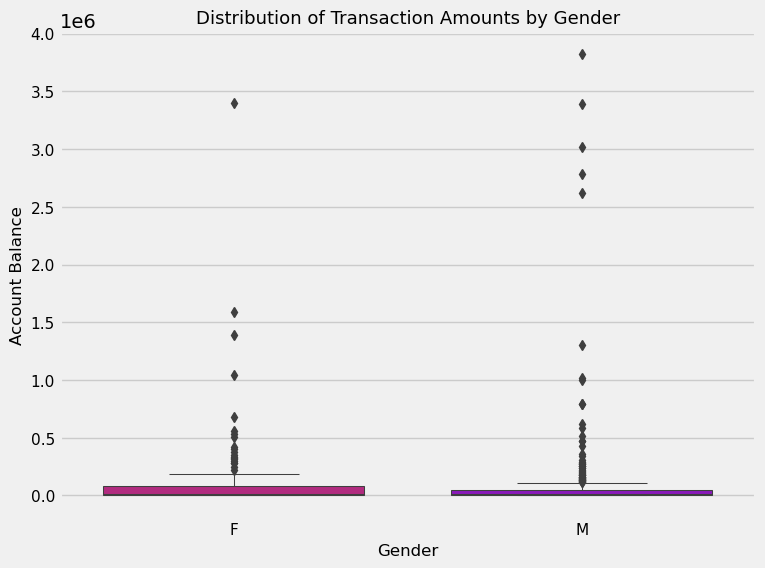

In [28]:
# Distribution of customers based on account balance
np.random.seed(4)
plt.figure(figsize=(8, 6))
sns.boxplot(x='gender',
            y='account_balance',
            data=df.sample(n=500),
            palette=custom_palette,
            width=.75,
            linewidth=.75)
plt.title('Distribution of Transaction Amounts by Gender',
          fontsize='13')
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Account Balance', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.show()

### 6.2. Distribution of transaction amounts based on gender

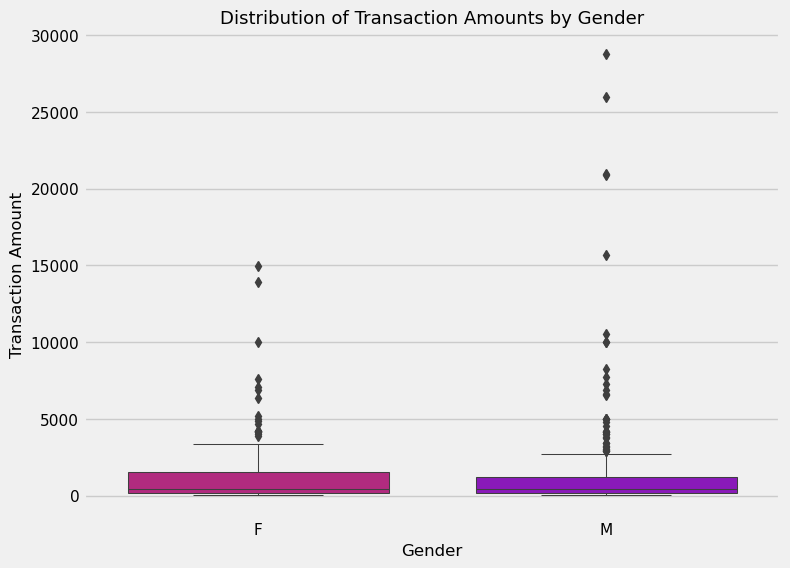

In [29]:
# Distribution of transaction amounts based on gender
np.random.seed(3)
plt.figure(figsize=(8, 6))
sns.boxplot(x='gender',
            y='transaction_amount',
            data=df.sample(n=500),
            palette=custom_palette,
            width=.75,
            linewidth=.75)
plt.title('Distribution of Transaction Amounts by Gender',
          fontsize='13')
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Transaction Amount', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.show()

### 6.3. Distribution of Account Balance based on customer Age

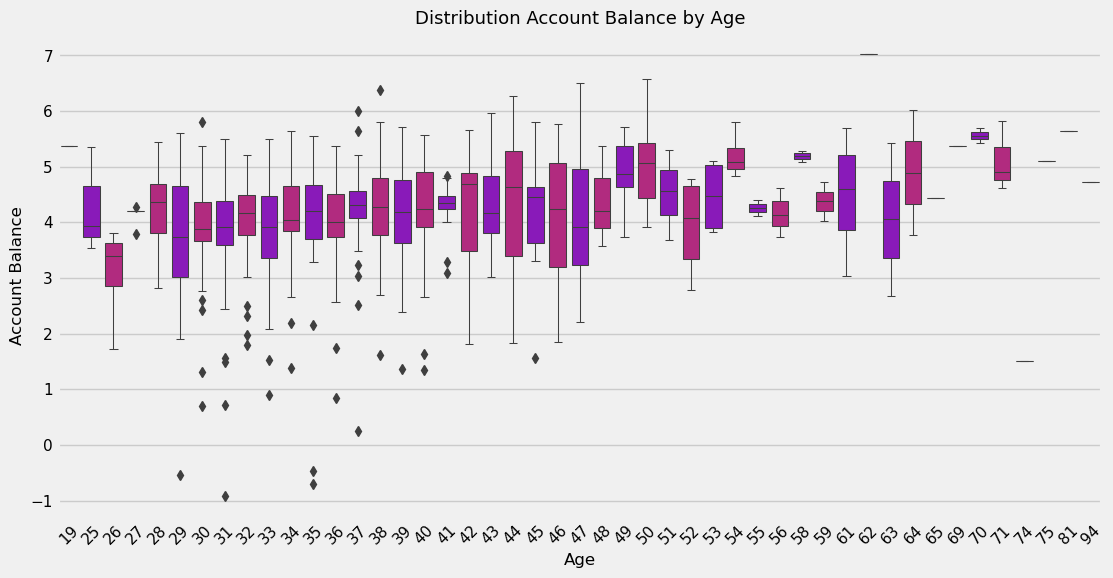

In [33]:
np.random.seed(1)
plt.figure(figsize=(12, 6))
sns.boxplot(x='age',
            y='log_account_balance',
            data=df.sample(n=500),
            palette=custom_palette,
            width=.75,
            linewidth=.75)
plt.title('Distribution Account Balance by Age',
          fontsize='13')
plt.xlabel('Age', fontsize=12)
plt.ylabel('Account Balance', fontsize=12)
plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=11)
plt.show()

### 6.4. Distribution of Transaction Amount based on customer Age

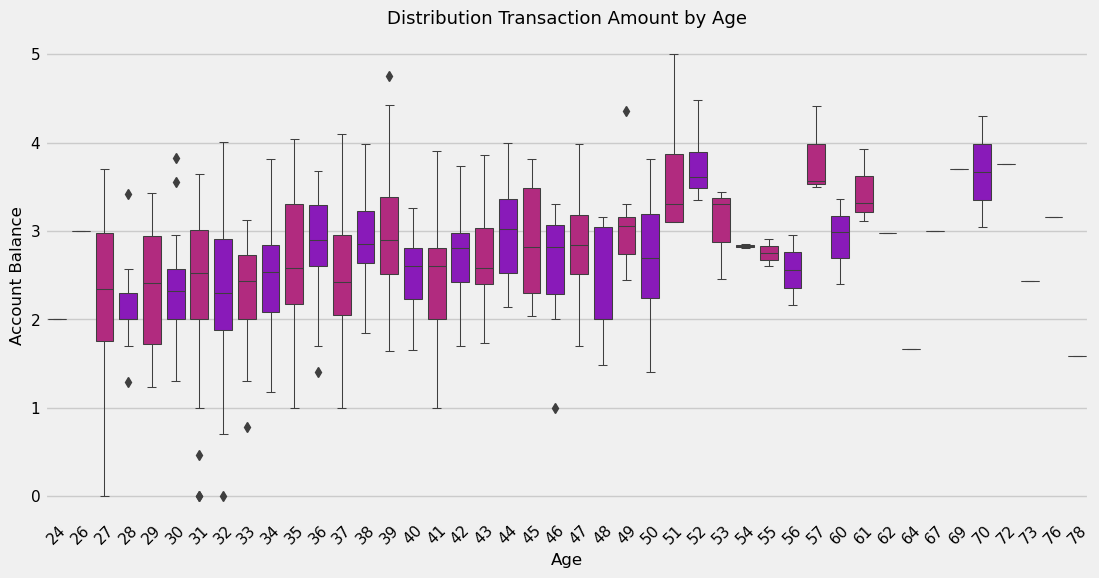

In [31]:
np.random.seed(2)
plt.figure(figsize=(12, 6))
sns.boxplot(x='age',
            y='log_transaction_amount',
            data=df.sample(n=500),
            palette=custom_palette,
            width=.75,
            linewidth=.75)
plt.title('Distribution Transaction Amount by Age',
          fontsize='13')
plt.xlabel('Age', fontsize=12)
plt.ylabel('Account Balance', fontsize=12)
plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=11)
plt.show()

### 6.5. Most 10 frequent Customer Location

Text(0.5, 1.0, 'Most 10 Location of Customer ')

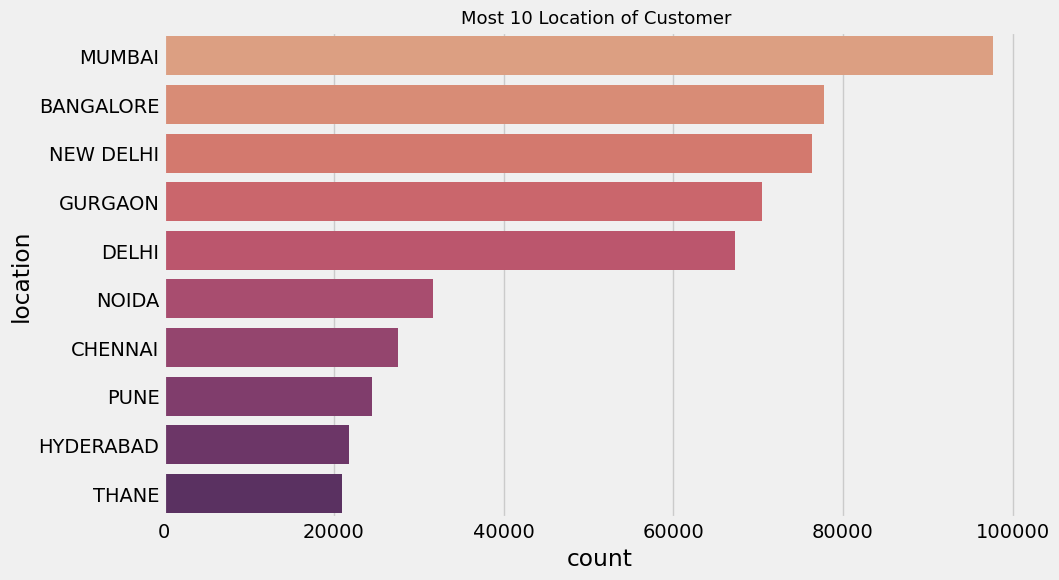

In [34]:
plt.figure(figsize=(10,6))
chart=sns.countplot(y='location',
                    data=df,
                    palette='flare',
                    order = df['location'].value_counts()[:10].index)
plt.title("Most 10 Location of Customer ",
          fontsize='13')


## 7. Temporal Analysis:

We want to analyze trends over time using the `transaction_date` column. We can aggregate data based on dates (daily, monthly, yearly) and visualize trends or patterns. We also can check if there are any specific patterns or anomalies in transaction times (`Transaction_time) throughout the day.

In [35]:
df['year'] = df['transaction_date'].dt.year
df['month'] = df['transaction_date'].dt.month
df['day'] = df['transaction_date'].dt.day
df['hour'] = (pd.to_datetime(df['transaction_time'], format='%H:%M:%S')).dt.hour
df['hour'] = df['hour'].astype(float)

In [36]:
df.head()

,transaction_id,customer_id,date_of_birth,gender,location,account_balance,transaction_date,transaction_time,transaction_amount,gender_int,age,log_account_balance,log_transaction_amount,year,month,day,hour
0,T1,C5841053,1994-01-10,F,JAMSHEDPUR,17819.05,2016-08-02,14:32:07,25.0,1,29,4.25,1.40,2016,8,2,14.0
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,2016-08-02,14:18:58,27999.0,0,66,3.36,4.45,2016,8,2,14.0
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,2016-08-02,14:27:12,459.0,1,26,4.25,2.66,2016,8,2,14.0
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2016-08-02,14:27:14,2060.0,1,50,5.94,3.31,2016,8,2,14.0
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,2016-08-02,18:11:56,1762.5,1,35,3.83,3.25,2016,8,2,18.0


In [37]:
hourly_transactions = df.groupby(by=['hour'])['transaction_amount'].sum()
daily_transactions = df.groupby('day')['transaction_amount'].sum()
monthly_transactions = df.groupby(by=['month'])['transaction_amount'].sum()
yearly_transactions = df.groupby(by=['year'])['transaction_amount'].sum()

In [38]:
hourly_transactions = hourly_transactions / 1000000
daily_transactions = daily_transactions / 1000000
monthly_transactions = monthly_transactions / 1000000
yearly_transactions = yearly_transactions / 1000000

Text(0.5, 0, 'Daily hour')

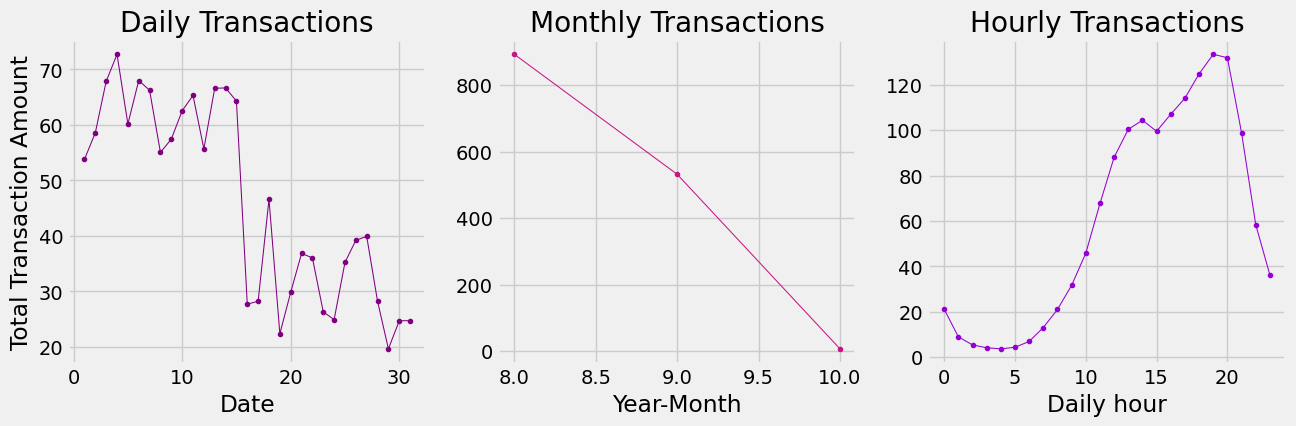

In [39]:
# Visualize trends over time
plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
daily_transactions.plot(marker='o',
                        markersize=3,
                        color='purple',
                        linewidth = .75)
plt.title('Daily Transactions')
plt.xlabel('Date')
plt.ylabel('Total Transaction Amount')

plt.subplot(1, 3, 2)
monthly_transactions.plot(marker='o',
                          markersize=3,
                          color='mediumvioletred',
                          linewidth = .75)
plt.title('Monthly Transactions')
plt.xlabel('Year-Month')

plt.subplot(1, 3, 3)
hourly_transactions.plot(marker='o',
                         markersize=3,
                         color='darkviolet',
                         linewidth = .75)
plt.title('Hourly Transactions')
plt.xlabel('Daily hour')

## 8. Outlier Detection:

Box plots have already been used before, and outliers were found. Now, we are going to calculate quantiles in order to handle those outliers in numerical columns. At first sight, we can hypothesize that these outliers are genuine data points

In [41]:
Q1 = df['account_balance'].quantile(0.25)
Q3 = df['account_balance'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_non_outliers = df[(df['account_balance'] >= lower_bound) & (df['account_balance'] <= upper_bound)]

In [42]:
outliers_deleted = df.shape[0] - df_non_outliers.shape[0]
outliers_deleted

130660

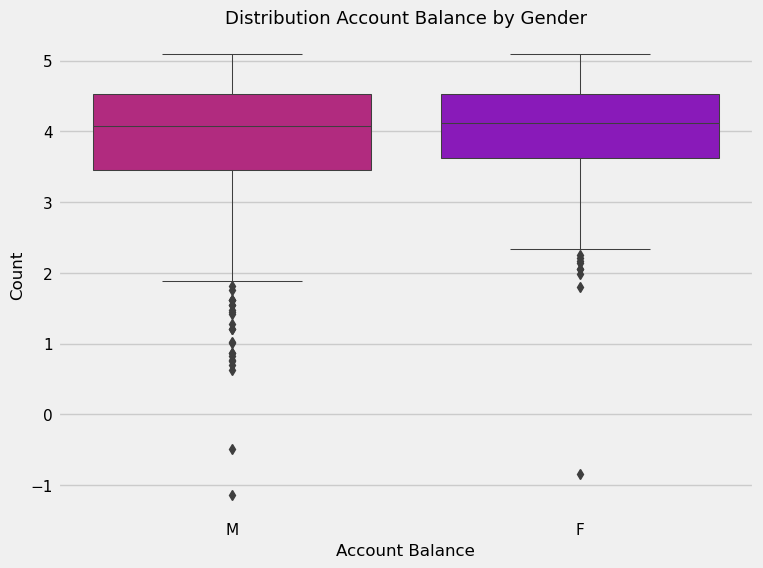

In [43]:
# Distribution of customers based on account balance
np.random.seed(6)
plt.figure(figsize=(8, 6))
sns.boxplot(x='gender', y='log_account_balance',
            data=df_non_outliers.sample(n=500),
            palette=custom_palette, linewidth = .75)
plt.title('Distribution Account Balance by Gender', fontsize=13)
plt.xlabel('Account Balance', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.show()

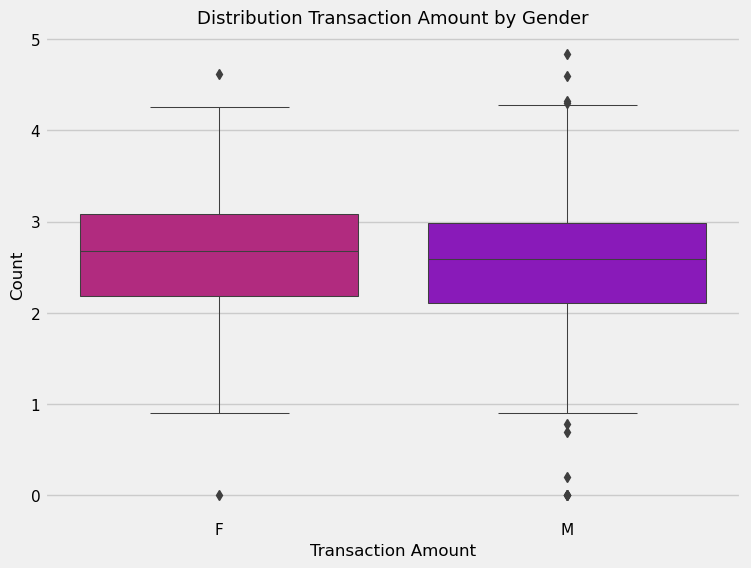

In [44]:
# Distribution of customers based on account balance
np.random.seed(7)
plt.figure(figsize=(8, 6))
sns.boxplot(x='gender',
            y='log_transaction_amount',
            data=df_non_outliers.sample(n=1000),
            palette=custom_palette,
            linewidth = .75)
plt.title('Distribution Transaction Amount by Gender', fontsize=13)
plt.xlabel('Transaction Amount', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.show()

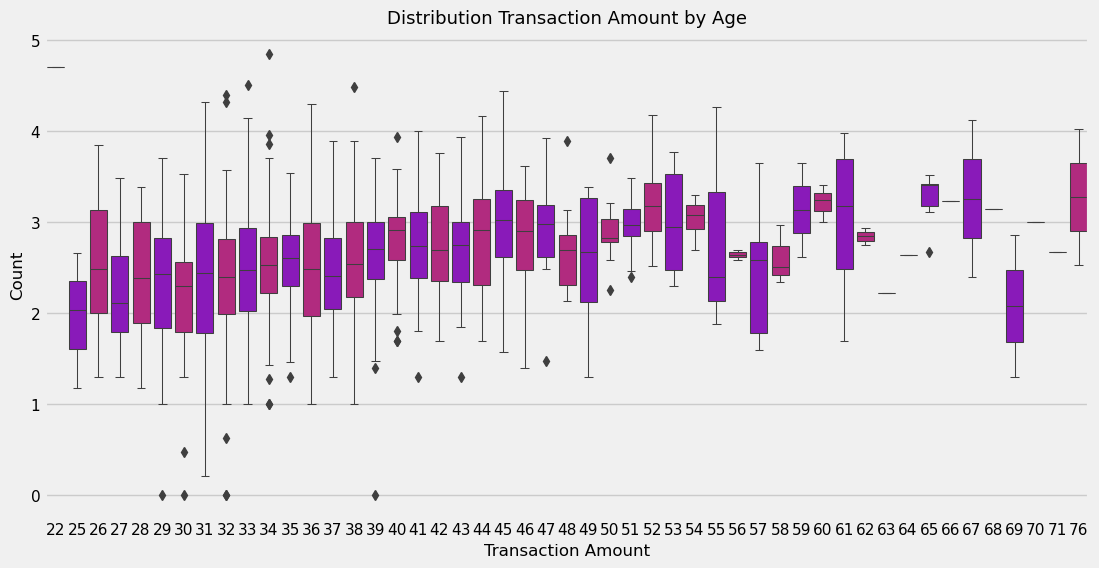

In [46]:
np.random.seed(11)
plt.figure(figsize=(12, 6))
sns.boxplot(x='age',
            y='log_transaction_amount',
            data=df_non_outliers.sample(n=1000),
            palette=custom_palette,
            linewidth = .75)
plt.title('Distribution Transaction Amount by Age', fontsize=13)
plt.xlabel('Transaction Amount', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.show()

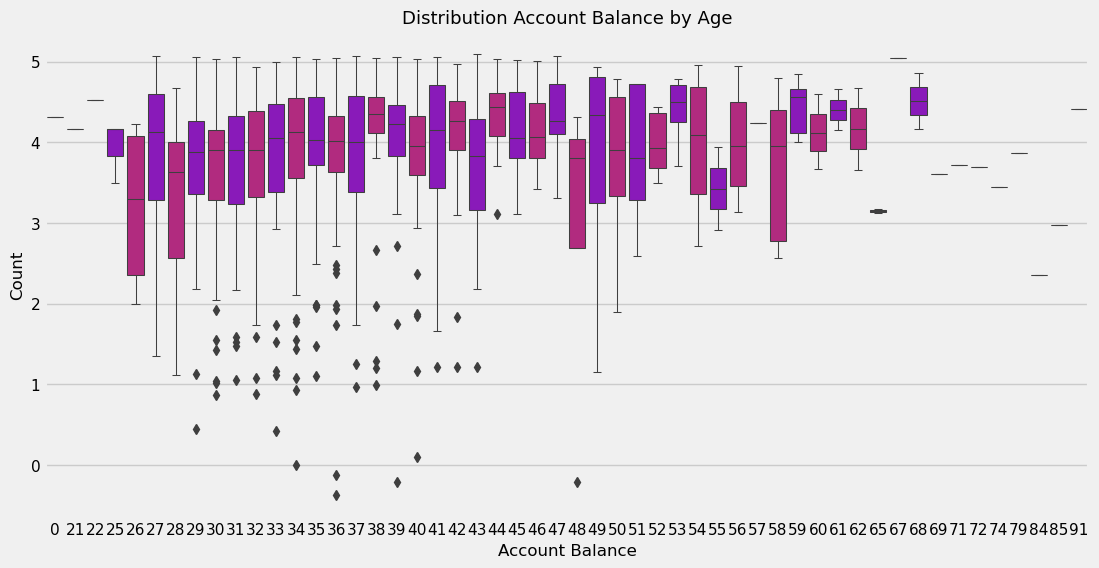

In [48]:
np.random.seed(12)
plt.figure(figsize=(12, 6))
sns.boxplot(x='age',
            y='log_account_balance',
            data=df_non_outliers.sample(n=1000),
            palette=custom_palette,
            linewidth = .75)
plt.title('Distribution Account Balance by Age', fontsize=13)
plt.xlabel('Account Balance', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.show()

## 9. Recency
Given we need to calculate Recency, Frequency and Monetary Value (Revenue from now on) in order to apply some supervised machine learning to identify different groups of customer segment for each.

Recency, refers to how recently a customer made a purchase. To calculate recency, the first step involves identifying the most recent purchase date for each customer. Once this date is determined, the system computes the number of days each customer has remained inactive. This measure of inactivity becomes crucial in comprehending customer behavior patterns, as a longer period of inactivity might indicate a decline in engagement or potential churn,

This method enables companies to identify and focus on customers who have been inactive for varying durations, facilitating targeted re-engagement efforts and enhancing overall customer relationship management strategies.


In [49]:
min_date = df.transaction_date.min()
max_date = df.transaction_date.max()
print(min_date, max_date)

2016-08-01 00:00:00 2016-10-21 00:00:00


In [50]:
#get the max transaction date for each customer and create a dataframe with it
max_transaction_date = df.groupby('customer_id').transaction_date.max().reset_index()
max_transaction_date.columns = ['customer_id','max_transaction_date']

user_data = df.groupby('customer_id').agg({
    'transaction_id':'count',
    'age':'first',
    'gender':'first',
    'location':'first',
    'account_balance':'mean',
    'transaction_amount':'mean'
})

user_data = user_data.reset_index()

max_transaction_date['recency'] = (max_transaction_date['max_transaction_date'].max() - 
                                   max_transaction_date['max_transaction_date']).dt.days


user_data = pd.merge(user_data, max_transaction_date[['customer_id', 'recency']], on='customer_id')

user_data.head()

,customer_id,transaction_id,age,gender,location,account_balance,transaction_amount,recency
0,C1010011,2,31,F,NOIDA,76340.635,2553.0,25
1,C1010012,1,29,M,MUMBAI,24204.490,1499.0,68
2,C1010014,2,31,F,MUMBAI,100112.950,727.5,75
3,C1010018,1,33,F,CHAMPARAN,496.180,30.0,36
4,C1010024,1,58,M,KOLKATA,87058.650,5000.0,64


In [51]:
user_data.describe()

,transaction_id,age,account_balance,transaction_amount,recency
count,839081.000000,839081.000000,8.390810e+05,8.390810e+05,839081.000000
mean,1.174287,37.884558,1.058545e+05,1.453624e+03,55.407673
std,0.435129,8.753689,7.862524e+05,6.045200e+03,15.220227
min,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000
25%,1.000000,32.000000,5.366190e+03,1.800000e+02,43.000000
50%,1.000000,36.000000,1.768220e+04,4.750000e+02,55.000000
75%,1.000000,41.000000,5.723652e+04,1.175730e+03,68.000000
max,6.000000,99.000000,1.150355e+08,1.560035e+06,81.000000


We see that the average is 55 day recency, median is 55 as well and percentil 75 is 68.

Text(0, 0.5, 'Count')

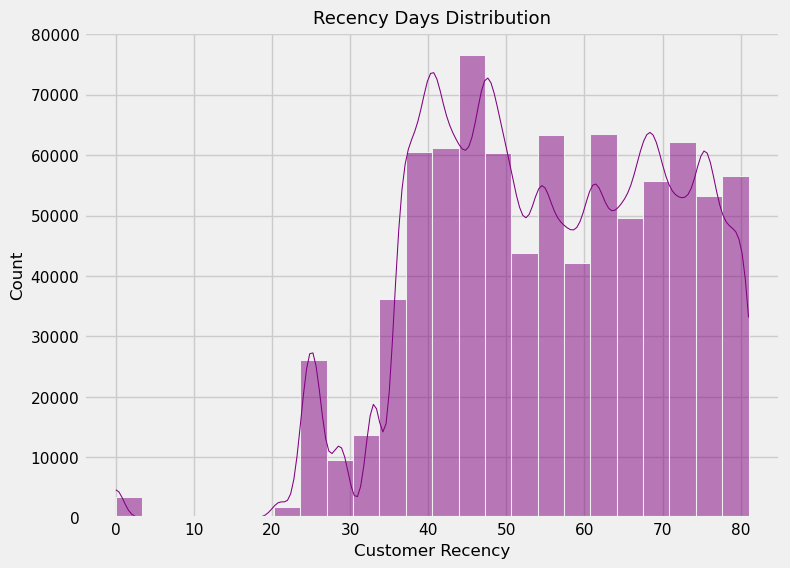

In [52]:
#plot histogram of recency
plt.figure(figsize=(8, 6))
sns.histplot(user_data['recency'],
             bins=24,
             kde=True,
             color='purple',
             linewidth = .75,
             line_kws=dict(linewidth=0.75))
plt.title('Recency Days Distribution', fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel('Customer Recency', fontsize=12)
plt.ylabel('Count', fontsize=12)

## 10. Frequency

It refers to the total number transaction for each customer.

In [53]:
user_frequency = df.groupby('customer_id').transaction_date.count().reset_index()
user_frequency.columns = ['customer_id','frequency']
user_data = pd.merge(user_data, user_frequency, on='customer_id')
user_data.head()

,customer_id,transaction_id,age,gender,location,account_balance,transaction_amount,recency,frequency
0,C1010011,2,31,F,NOIDA,76340.635,2553.0,25,2
1,C1010012,1,29,M,MUMBAI,24204.490,1499.0,68,1
2,C1010014,2,31,F,MUMBAI,100112.950,727.5,75,2
3,C1010018,1,33,F,CHAMPARAN,496.180,30.0,36,1
4,C1010024,1,58,M,KOLKATA,87058.650,5000.0,64,1


In [54]:
user_data.describe()

,transaction_id,age,account_balance,transaction_amount,recency,frequency
count,839081.000000,839081.000000,8.390810e+05,8.390810e+05,839081.000000,839081.000000
mean,1.174287,37.884558,1.058545e+05,1.453624e+03,55.407673,1.174287
std,0.435129,8.753689,7.862524e+05,6.045200e+03,15.220227,0.435129
min,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,1.000000
25%,1.000000,32.000000,5.366190e+03,1.800000e+02,43.000000,1.000000
50%,1.000000,36.000000,1.768220e+04,4.750000e+02,55.000000,1.000000
75%,1.000000,41.000000,5.723652e+04,1.175730e+03,68.000000,1.000000
max,6.000000,99.000000,1.150355e+08,1.560035e+06,81.000000,6.000000


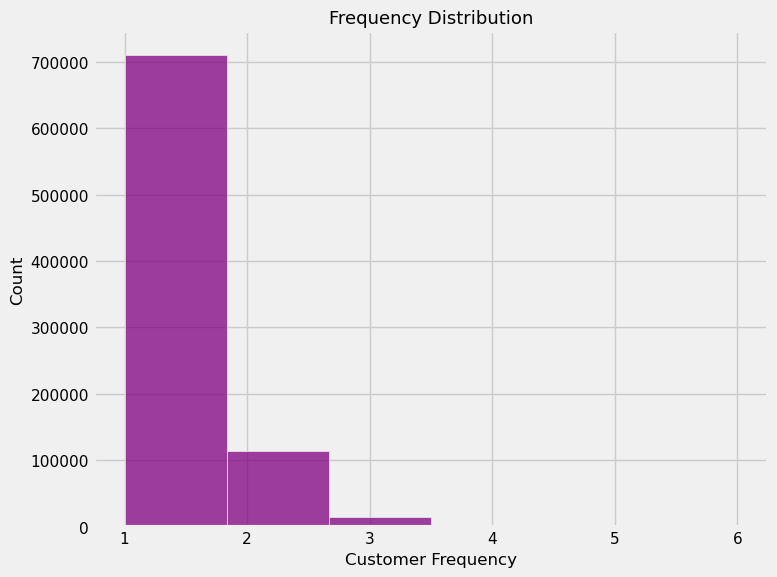

In [55]:
#plot histogram of frequency
plt.figure(figsize=(8, 6))
sns.histplot(user_data['frequency'], bins=6, color='purple')
plt.title('Frequency Distribution', fontsize=13)
plt.xlabel('Customer Frequency', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()

Text(0, 0.5, 'Account Balance')

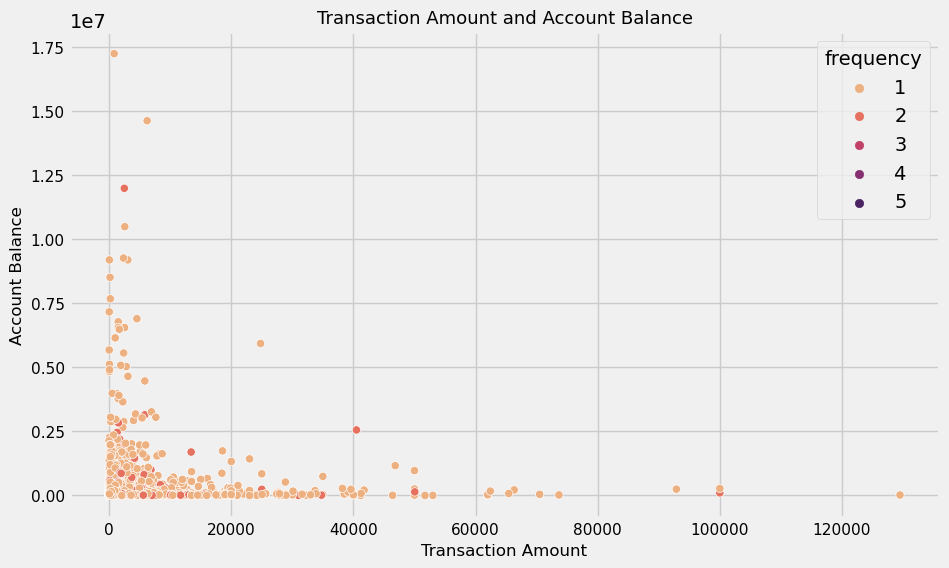

In [56]:
np.random.seed(10)
plt.figure(figsize=(10, 6))
sns.scatterplot(x='transaction_amount',y='account_balance',
                data=user_data.sample(n=10000),
                palette='flare',
                hue='frequency')
plt.title("Transaction Amount and Account Balance",
          fontsize='13')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xlabel('Transaction Amount', fontsize=12)
plt.ylabel('Account Balance',fontsize=12)


## 11. Monetary Value (Revenue)
Unless the bank entity sets a fee per transaction, we'll consider there are no fees. Therefore, we are unable to calculate proper revenue for each transaction or customer in this case.

## 12. Customer Segmentation (Target variable)

Once data analysis is finished and relevant metrics such as `recency` and `frequency` have been calculated for every customer, it is necessary to determine which segment every customer belongs to.

There are many methods for customer segmentation based on deciles, ranging from classical statistical methods to more sophisticated solutions, such as using unsupervised machine learning methods like K-Means, for instance.

In this case, we are going to calculate `Recency and Frequency scores` by estimating deciles with pandas `qcut`. Next, the scores are going to be combined into a single `RF score`. The weighted sum of the scores will be used.

According to [Handojo et al. (2023)](https://www.tandfonline.com/doi/full/10.1080/23311916.2022.2162679), for datasets with more than 1 month of transaction or purchase dates to analyze, the frequency weight should be `0.3`. However, as Monetary was not calculated in this case, and the weight sum must be equal to 1, after normalizing weights, we get:

* Rencency Weight: `0.2`
* Frequency Weight: `0.8`


In [57]:
# Calculate R and F scores using deciles and then we calculate
# the combined RFM score as the weighted sum.
weight_R = 0.2
weight_F = 0.8

user_data['R_score'] = pd.qcut(user_data['recency'], q=10, labels=False)
user_data['F_score'] = pd.qcut(user_data['frequency'], q=10,
                               duplicates='drop',
                               labels=False)
user_data['RF_score'] = (user_data['R_score'] * weight_R +
                         user_data['F_score'] * weight_F)

In [58]:
# Define RF segments based on score ranges and apply it to Dataframe
segments = {
    'A': (user_data['RF_score'] >= user_data['RF_score'].quantile(0.75)),
    'B': (user_data['RF_score'] >= user_data['RF_score'].quantile(0.25)) &
     (user_data['RF_score'] < user_data['RF_score'].quantile(0.75)),
    'C': (user_data['RF_score'] < user_data['RF_score'].quantile(0.25))
    }
user_data['RF_segment'] = np.select(segments.values(), segments.keys(), default='Other')

user_data.head()

,customer_id,transaction_id,age,gender,location,account_balance,transaction_amount,recency,frequency,R_score,F_score,RF_score,RF_segment
0,C1010011,2,31,F,NOIDA,76340.635,2553.0,25,2,0,0,0.0,C
1,C1010012,1,29,M,MUMBAI,24204.490,1499.0,68,1,7,0,1.4,A
2,C1010014,2,31,F,MUMBAI,100112.950,727.5,75,2,8,0,1.6,A
3,C1010018,1,33,F,CHAMPARAN,496.180,30.0,36,1,0,0,0.0,C
4,C1010024,1,58,M,KOLKATA,87058.650,5000.0,64,1,6,0,1.2,B


## 13. Mutual Information Analysis

Since we have more categorical features than continuous ones, and our target variable is discrete (segmentation), we will use the mutual information classifier next:

In [61]:
user_data['gender_int'] = user_data['gender'].map({'F': 0, 'M': 1})

In [62]:
# To estimate mutual information for a discrete target variable.
features = user_data[['account_balance',
                      'transaction_amount',
                      'age',
                      'gender_int',
                      'R_score',
                      'F_score']]

# it takes some time, be patient
mutual_info_score = mutual_info_classif(features, user_data['RF_segment'])

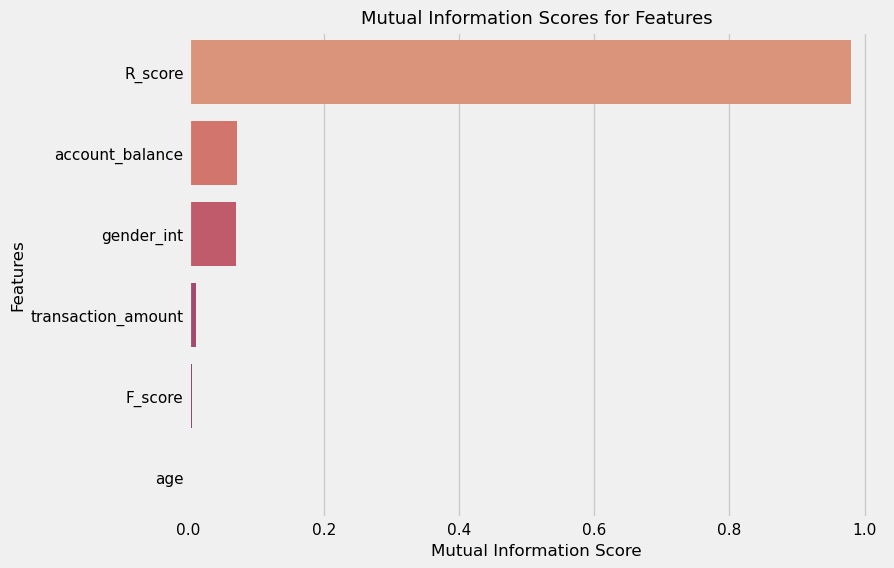

In [63]:
feature_scores = pd.DataFrame({'Feature': features.columns,
                               'Mutual_Info_Score': mutual_info_score})

sorted_scores = feature_scores.sort_values(by='Mutual_Info_Score',
                                           ascending=False)
plt.figure(figsize=(8, 6))
sns.barplot(x='Mutual_Info_Score', y='Feature',
            data=sorted_scores,
            palette='flare')
plt.xlabel('Mutual Information Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Mutual Information Scores for Features', fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.show()

As we can see, after applying diverse methods to determine possible relationship between features themselves and mutual information with target variable (`RF_segment`) we have reduced dimensionality of dataset:

#### **Features**:

* `account_balance`
* `transaction_amount`
* `gender_int`
* `R_score`

#### **Target**:

* `RF_segment`


## 14. Final Dataset

In [64]:
user_data.head(10)

,customer_id,transaction_id,age,gender,location,account_balance,transaction_amount,recency,frequency,R_score,F_score,RF_score,RF_segment,gender_int
0,C1010011,2,31,F,NOIDA,76340.635,2553.0,25,2,0,0,0.0,C,0
1,C1010012,1,29,M,MUMBAI,24204.490,1499.0,68,1,7,0,1.4,A,1
2,C1010014,2,31,F,MUMBAI,100112.950,727.5,75,2,8,0,1.6,A,0
3,C1010018,1,33,F,CHAMPARAN,496.180,30.0,36,1,0,0,0.0,C,0
4,C1010024,1,58,M,KOLKATA,87058.650,5000.0,64,1,6,0,1.2,B,1
5,C1010028,1,35,F,DELHI,296828.370,557.0,53,1,4,0,0.8,B,0
6,C1010031,2,39,M,VAPI,5200.155,932.0,78,2,9,0,1.8,A,1
7,C1010035,2,31,M,MUMBAI,192648.755,375.0,55,2,4,0,0.8,B,1
8,C1010036,1,27,M,GURGAON,355430.170,208.0,56,1,5,0,1.0,B,1
9,C1010037,1,42,M,BANGALORE,95859.170,19680.0,73,1,8,0,1.6,A,1


## 15. References:

* Andreas Handojo, Nyoman Pujawan, Budi Santosa & Moses Laksono Singgih (2023) A multi layer recency frequency monetary method for customer priority segmentation in online transaction, Cogent Engineering, 10:1, DOI: 10.1080/23311916.2022.2162679